In [24]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
try:
    from tqdm import tqdm
except:
    print('TQDM not availabe....')
    tqdm = lambda x: x

In [25]:
#helper functions
def make_mask(center, diam, z, width, height, spacing, origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height, width])  # 0's everywhere except nodule swapping x,y to match img
    # convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center - origin) / spacing
    v_diam = int(diam / spacing[0] + 5)
    v_xmin = np.max([0, int(v_center[0] - v_diam) - 5])
    v_xmax = np.min([width - 1, int(v_center[0] + v_diam) + 5])
    v_ymin = np.max([0, int(v_center[1] - v_diam) - 5])
    v_ymax = np.min([height - 1, int(v_center[1] + v_diam) + 5])

    v_xrange = range(v_xmin, v_xmax + 1)
    v_yrange = range(v_ymin, v_ymax + 1)

    # Convert back to world coordinates for distance calculation
    x_data = [x * spacing[0] + origin[0] for x in range(width)]
    y_data = [x * spacing[1] + origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0] * v_x + origin[0]
            p_y = spacing[1] * v_y + origin[1]
            if np.linalg.norm(center - np.array([p_x, p_y, z])) <= diam:
                mask[int((p_y - origin[1]) / spacing[1]), int((p_x - origin[0]) / spacing[0])] = 1.0
    return (mask)


def matrix2int16(matrix):
    m_min = np.min(matrix)
    m_max = np.max(matrix)
    matrix = matrix - m_min
    return (np.array(np.rint((matrix - m_min) / float(m_max - m_min) * 65535.0), dtype=np.uint16))

# Getting list of image files
luna_path = "C:/Users/mail2/Desktop/LUNA_16_dataset/"
luna_subset_path = luna_path + "subset1/"
output_path = "C:/Users/mail2/Desktop/LUNA_16_dataset/output_subset_1/"
file_list = glob(luna_subset_path + "*.mhd")


# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return (f)


#
# The locations of the nodes
df_node = pd.read_csv(luna_path + "annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

#####
#
# Looping over the image files
#
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"] == img_file]  # get all nodules associate with file
    if mini_df.shape[0] > 0:  # some files may not have a nodule--skipping those
        # load the data once
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img)  # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape  # heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())  # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())  # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([3, height, width], dtype=np.float32)
            masks = np.ndarray([3, height, width], dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])  # nodule center
            v_center = np.rint((center - origin) / spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2]) - 1,
                                              int(v_center[2]) + 2).clip(0,
                                                                         num_z - 1)):  # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z * spacing[2] + origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            np.save(os.path.join(output_path, "images_%04d_%04d.npy" % (fcount, node_idx)), imgs)
            np.save(os.path.join(output_path, "masks_%04d_%04d.npy" % (fcount, node_idx)), masks)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [02:00<00:00,  2.38s/it]


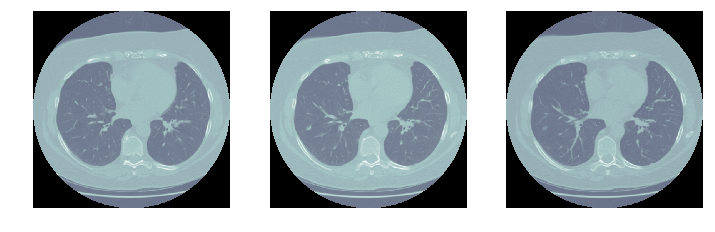

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

working_path = "C:/Users/mail2/Desktop/LUNA_16_dataset/output_final/"
img_file = working_path + "images_0088_1180.npy"

imgs_to_process = np.load(img_file).astype(np.float64)
fig = plt.figure(figsize=(12,4))
for i in range(3):
  ax = fig.add_subplot(1,3,i+1)
  ax.imshow(imgs_to_process[i,:,:], 'bone')
  ax.set_axis_off()

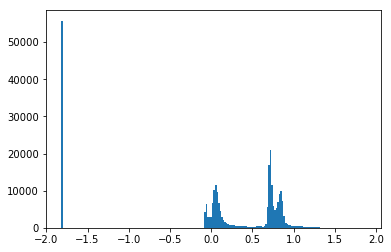

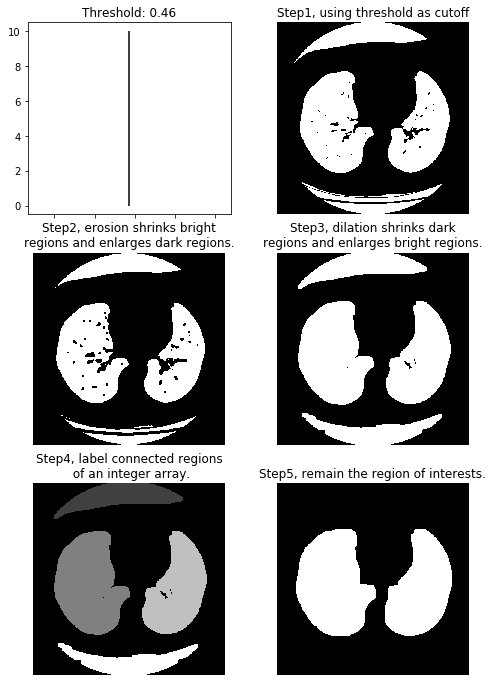

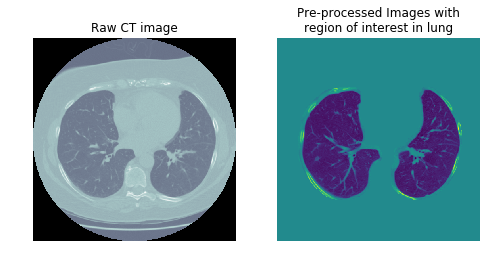

In [2]:
i = 0
img = imgs_to_process[i]
#Standardize the pixel values
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
plt.hist(img.flatten(),bins=200)
# Find the average pixel value near the lungs
#　to renormalize washed out images
middle = img[100:400,100:400]
mean = np.mean(middle)
max = np.max(img)
min = np.min(img)
# To improve threshold finding, I'm moving the
#　underflow and overflow on the pixel spectrum
img[img==max]=mean
img[img==min]=mean

# Using Kmeans to separate foreground (radio-opaque tissue)
#　and background (radio transparent tissue ie lungs)
# Doing this only on the center of the image to avoid
#　the non-tissue parts of the image as much as possible
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0) # threshold the image


fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(321)
# sns.distplot(middle.ravel(), ax=ax1)
ax1.vlines(x=threshold, ymax=10, ymin=0)
ax1.set_title('Threshold: %1.2F' % threshold)
ax1.set_xticklabels([])


ax2 = fig.add_subplot(322)
ax2.imshow(thresh_img, "gray")
ax2.set_axis_off()
ax2.set_title('Step1, using threshold as cutoff')


eroded = morphology.erosion(thresh_img,np.ones([4,4]))
ax3 = fig.add_subplot(323)
ax3.imshow(eroded, "gray")
ax3.set_axis_off()
ax3.set_title('Step2, erosion shrinks bright\nregions and enlarges dark regions.')


dilation = morphology.dilation(eroded,np.ones([10,10]))
ax4 = fig.add_subplot(324)
ax4.imshow(dilation, "gray")
ax4.set_axis_off()
ax4.set_title('Step3, dilation shrinks dark\nregions and enlarges bright regions.')


labels = measure.label(dilation)
ax5 = fig.add_subplot(325)
ax5.imshow(labels, "gray")
ax5.set_axis_off()
ax5.set_title('Step4, label connected regions\n of an integer array.')

regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
  B = prop.bbox
  if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
    good_labels.append(prop.label)

mask = np.zeros_like(labels)
for N in good_labels:
  mask = mask + np.where(labels==N,1,0)

mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

ax6 = fig.add_subplot(326)
ax6.imshow(mask, "gray")
ax6.set_axis_off()
ax6.set_title('Step5, remain the region of interests.')

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imgs_to_process[0,:,:], 'bone')
ax1.set_axis_off()
ax1.set_title("Raw CT image")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(imgs_to_process[2,:,:]*mask)
ax2.set_axis_off()
ax2.set_title("Pre-processed Images with\nregion of interest in lung")